# Flavours of Gradient Descent

A quick recap of the Gradient Descent method: This is an iterative algorithm to minize a loss function $L(x)$, where we start with a guess of what the answer should be - and then take steps proportional to the gradient at the current point.

$x = x_0$ (initial guess)

Until Convergence is achieved:
    
$x_{i+1} = x_{i} - \eta\nabla_L(x_i)$

For example, Let's say $L(x) = x^2 - 2x + 1$ and we start at $x0 = 2$. Coding the Gradient Descent method in Python:

In [2]:
%matplotlib inline

In [3]:
import numpy as np

def L(x):
    return x**2 - 2*x + 1

def L_prime(x):
    return 2*x - 2


def converged(x_prev, x, epsilon):
    "Return True if the abs value of all elements in x-x_prev are <= epsilon."
    
    absdiff = np.abs(x-x_prev)
    return np.all(absdiff <= epsilon)


def gradient_descent(f_prime, x_0, learning_rate=0.2, n_iters=100, epsilon=1E-8):
    x = x_0
    
    for _ in range(n_iters):
        x_prev = x
        x -= learning_rate*f_prime(x)
        
        if converged(x_prev, x, epsilon):
            break
            
    return x

x_min = gradient_descent(L_prime, 2)

print('Minimum value of L(x) = x**2 - 2*x + 1.0 is [%.2f] at x = [%.2f]' % (L(x_min), x_min))


Minimum value of L(x) = x**2 - 2*x + 1.0 is [0.00] at x = [1.00]


## Batch Gradient Descent

In most supervised ML applications, we will try to learn a pattern from a number of labeled examples. In Batch Gradient Descent, each iteration loops over entire set of examples.

So, let's build 1-layer network of Linear Perceptrons to classify Fisher's IRIS dataset (again!). Remember that a Linear Perceptron can only distinguish between two classes. 

<table>
    <tr>
        <td><img src="http://blog.zabarauskas.com/img/perceptron.gif"></td>
        <td><img src="http://cmp.felk.cvut.cz/cmp/courses/recognition/Labs/perceptron/images/linear.png" />        
    </tr>
</table>

Since there are 3 classes, our mini-network will have 3 Perceptrons. We'll channel the output
of each Perceptron $w_i^T + b$ into a softmax function to pick the final label.  We'll train this network using Batch Gradient Descent.


## Getting Data

In [4]:
import seaborn as sns
import pandas as pd

iris_df = sns.load_dataset('iris')
print('Columns: %s' % (iris_df.columns.values, ))
print('Labels:  %s' % (pd.unique(iris_df['species']), ))

iris_df.head(5)


Columns: ['sepal_length' 'sepal_width' 'petal_length' 'petal_width' 'species']
Labels:  ['setosa' 'versicolor' 'virginica']


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## The Softmax Function

The softmax function is a technique to apply a probabilistic classifier by making a probability distribution out of a set of values $(v_1, v_2, ..., v_n)$ which may or may not satisfy all the features of probability distribution: 

- $v_i >= 0$
- $\sum_{i=1}^n v_i = 1$

The probability distribution is the Gibbs Distribution: $v'_i = \frac {\exp {v_i}} {\sum_{j=1}^n\exp {v_j})}$ for $i = 1, 2, ... n$.


In [5]:
def softmax(x):
    # Uncomment to find out why we shouldn't do it this way...
    # return np.exp(x) / np.sum(np.exp(x))
    scaled_x = x - np.max(x)    
    result = np.exp(scaled_x) / np.sum(np.exp(scaled_x))
    return result

a = np.array([-500.9, 2000, 7, 11, 12, -15, 100])
sm_a = softmax(a)
print('Softmax(%s) = %s' % (a, sm_a))

Softmax([ -500.9  2000.      7.     11.     12.    -15.    100. ]) = [ 0.  1.  0.  0.  0.  0.  0.]


## Non-linear Perceptron With SoftMax

With softmax, we typically use the cross-entropy error as the function to minimize.

The Cross Entropy Error for a given input $X = (x_1, x_2, ..., x_n)$, where each $x_i$ is a vector, is given by:

$L(x) = - \frac {1}{n} \sum_{i=1}^n y_i^T log(\hat{y_i})$

Where

- The sum runs over $X = (x_1, x_2, ..., x_n)$.
- Each $y_i$ is the 1-of-n encoded label of the $i$-th example, so it's also a vector. For example, if the labels in order are ('apple', 'banana', 'orange') and the label of $x_i$ is 'banana', then $y_i = [0, 1, 0]$.
- $\hat{y_i}$ is the softmax output for $x_i$ from the network.
- The term $y_i^T log(\hat{y_i})$ is the vector dot product between $y_i$ and  $log(\hat{y_i})$.

## One of n Encoding

In [6]:
def encode_1_of_n(ordered_labels, y):
    label2idx = dict((label, idx)
                     for idx, label in enumerate(ordered_labels))
    
    def encode_one(y_i):        
        enc = np.zeros(len(ordered_labels))
        enc[label2idx[y_i]] = 1.0
        return enc
    
    return np.array([x for x in map(encode_one, y)])

encode_1_of_n(['apple', 'banana', 'orange'], 
              ['apple', 'banana', 'orange', 'apple', 'apple'])

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]])

## Cross Entropy Error

In [7]:
def cross_entropy_loss(Y, Y_hat):
    entropy_sum = 0.0    
    log_Y_hat = np.log(Y_hat)
    
    for y, y_hat in zip(Y, log_Y_hat):        
        entropy_sum += np.dot(y, y_hat)  
    
    return -entropy_sum/Y.shape[0]

Y_tst = np.array([[1, 0, 0], 
                  [0, 1, 0]])

# log(Y_hat_tst1) is the same as Y_tst, so we expect the x-entropy error to be the min (-1) in this case.
print(Y_tst)
Y_hat_tst1 = np.array([[np.e, 1, 1,],
                     [1, np.e, 1]])
print(Y_hat_tst1)
print(cross_entropy_loss(Y_tst, Y_hat_tst1))
print()

# expect it to be > -1
Y_hat_tst2 = np.array([[1, 1, 1,],
                     [1, np.e, 1]])
print(Y_hat_tst2)
print(cross_entropy_loss(Y_tst, Y_hat_tst2))
print()

[[1 0 0]
 [0 1 0]]
[[ 2.71828183  1.          1.        ]
 [ 1.          2.71828183  1.        ]]
-1.0

[[ 1.          1.          1.        ]
 [ 1.          2.71828183  1.        ]]
-0.5



## Gradient of the Cross Entropy Error

The Gradient update step in Gradient Descent when the Loss Function uses Cross Entropy Error is:

$w_i^{j+1} = w_i^{j} - \eta [\frac {\partial L} {\partial w_i}]^{j}$

In [11]:
import pandas as pd


class OneLayerNetworkWithSoftMax:
    
    def __init__(self):
        self.w, self.bias = None, 0.0
        self.optimiser = None
        self.output = None
        
    def init_weights(self, X, Y):
        """
        Initialize a 2D weight matrix as a Dataframe with 
        dim(n_labels*n_features).         
        """
        self.labels = np.unique(Y)
              
        w_init = np.random.randn(len(self.labels), X.shape[1])        
        self.w = pd.DataFrame(data=w_init)
        self.w.index.name = 'node_id'

    def predict(self, x):
        """
        Return the predicted label of x using current weights.
        """
        output = self.forward(x, update=False)
        max_label_idx = np.argmax(output)
        return self.labels[max_label_idx]

    def forward(self, x, update=True):
        """
        Calculate softmax(w^Tx+b) for x using current $w_i$ s.
        """
        #output = self.w.apply(lambda row: np.dot(row, x), axis=1)
        output = np.dot(self.w, x)
        output += self.bias
        
        output = softmax(output) 
        if update:
            self.output = output        
        return output
    
    def backward(self, x, y, learning_rate):
        """
        Executes the weight update step
        
            grad = (self.output - y)          
            
            for i in range(len(grad)):
                dw[i] -= grad[i] * x
                
            w -= learning_rate * dw
        
        :param x: one sample vector.
        :param y: One-hot encoded label for x.
        """
        
        # [y_hat1 - y1, y_hat2-y2, ... ]
        y_hat_min_y = self.output - y
        
        # Transpose the above to a column vector
        # and then multiply x with each element
        # to produce a 2D array (n_labels*n_features), same as w
        error_grad = np.apply_along_axis(lambda z: z*x , 
            1, np.atleast_2d(y_hat_min_y).T)
        self.w -= learning_rate * error_grad       
    
    def print_weight_diff(self, i, w_old, diff_only=True):
        if not diff_only:        
            print('Before Iteration [%s]: weights are: \n%s' % 
                  (i+1, w_old))

            print('After Iteration [%s]: weights are: \n%s' % 
                  (i+1, self.w))
        
        w_diff = np.abs(w_old - self.w)
        print('After Iteration [%s]: weights diff: \n%s' % 
              (i+1, w_diff))
                
    def train(self, X, Y, 
              n_iters=1000, 
              learning_rate=0.2,
              minibatch_size=20,
              epsilon=1E-8):
        """
        Entry point for the Minibatch SGD training method.
                      
        Calls forward+backward for each (x_i, y_i) pair and adjusts the
        weight w accordingly.        
        """
        print_every = n_iters/10
        
        self.init_weights(X, Y)    
        Y = encode_1_of_n(self.labels, Y)
        
        n_samples = X.shape[0]     
               
        # MiniBatch SGD
        for i in range(n_iters):
            batch_indices = np.random.randint(0, 
                n_samples-1, minibatch_size)
            
            X_batch = X[batch_indices, :]
            Y_batch = Y[batch_indices, :]
            
            w_old = self.w.copy()
            
            for x, y in zip(X_batch, Y_batch):
                self.forward(x)
                self.backward(x, y, learning_rate)
            
            if (i == 0) or ((i+1) % print_every == 0):
                self.print_weight_diff(i, w_old)          
                
                
# Set aside test data
label_grouper = iris_df.groupby('species')
test = label_grouper.head(10).set_index('species')
train = label_grouper.tail(100).set_index('species')

# Train the Network
X_train, Y_train = train.as_matrix(), train.index.values
nn = OneLayerNetworkWithSoftMax()
nn.train(X_train, Y_train)

# Test
results = test.apply(lambda row : nn.predict(row.as_matrix()), axis=1)
results.name = 'predicted_label'
results.index.name = 'expected_label'

results.reset_index()

After Iteration [1]: weights diff: 
                0         1         2         3
node_id                                        
0        0.782285  1.642967  1.951996  0.824500
1        0.737190  0.843614  0.218368  0.102663
2        0.045095  0.799353  1.733629  0.721837
After Iteration [100]: weights diff: 
                0         1         2             3
node_id                                            
0        0.006253  0.003468  0.000718  5.145190e-07
1        0.070761  0.033834  0.057067  1.906152e-02
2        0.077013  0.037302  0.057785  1.906100e-02
After Iteration [200]: weights diff: 
                0         1         2         3
node_id                                        
0        0.499088  0.340824  0.137474  0.013713
1        1.137667  0.626235  0.813392  0.236197
2        0.638579  0.285411  0.675918  0.222484
After Iteration [300]: weights diff: 
                0         1         2         3
node_id                                        
0        0.002

,expected_label,predicted_label
0,setosa,setosa
1,setosa,setosa
2,setosa,setosa
3,setosa,setosa
4,setosa,setosa
5,setosa,setosa
6,setosa,setosa
7,setosa,setosa
8,setosa,setosa
9,setosa,setosa


## Gradient of the Cross Entropy Error

**Recap** We know the the cross entropy error is the average of the vector products between the 1-hot enconding of label and the softmax output.

$L = - \frac {1}{n} \sum_{i=1}^n Y_i^T ln(\hat Y_i)$

Where the sum runs over all of the $n$ input samples.

This is a complex derivation, and we need to approach it step-by step. First, let's work out what the $i$-th sample contributes to the gradient of L, i.e. the derivative of - $Y_i^Tln(\hat Y_i)$.

Let's draw the structure of the Network using networkx for a 2-class problem, so we have 2 input nodes.

{('i', 'n1'): <matplotlib.text.Text at 0x294ab87dda0>,
 ('i', 'n2'): <matplotlib.text.Text at 0x294ab888470>,
 ('n1', 's1'): <matplotlib.text.Text at 0x294ab87d630>,
 ('n1', 's2'): <matplotlib.text.Text at 0x294ab882cc0>,
 ('n2', 's1'): <matplotlib.text.Text at 0x294ab53ef60>,
 ('n2', 's2'): <matplotlib.text.Text at 0x294ab888be0>,
 ('s1', 'y1'): <matplotlib.text.Text at 0x294ab882550>,
 ('s2', 'y2'): <matplotlib.text.Text at 0x294ab88d390>}

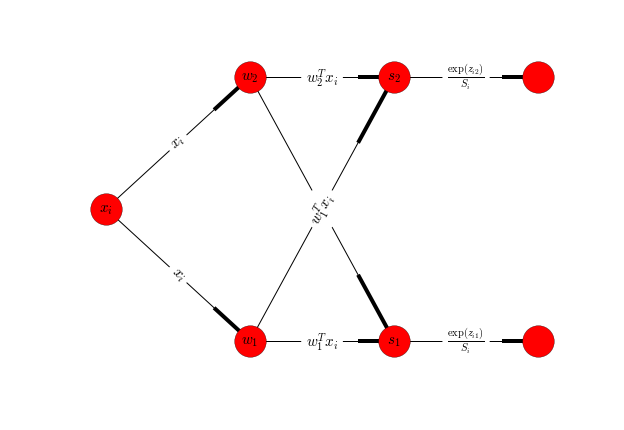

In [9]:
import networkx as nx
from matplotlib import pylab

G = nx.DiGraph()
G.add_edges_from(
    [('i', 'n1'), 
     ('i', 'n2'),
     ('n1', 's1'),
     ('n2', 's1'),
     ('n1', 's2'),
     ('n2', 's2'),
     ('s1', 'y1'),
     ('s2', 'y2'),
    ])

pos = {'i': (1, 1), 
       'n1': (2, 0), 'n2': (2, 2),
       's1': (3, 0), 's2': (3, 2),
       'y1': (4, 0), 'y2': (4, 2),
      }

labels = {'i': r'$x_i$',
         'n1': r'$w_1$', 'n2': r'$w_2$',
         's1': r'$s_1$', # r'$\frac {\exp(z_{i1})} {S_i}$', 
         's2': r'$s_2$', # r'$\frac {\exp(z_{i2})} {S_i}$'         
         }

edge_labels = {('i', 'n1'): r'$x_i$', 
               ('i', 'n2'): r'$x_i$',
               ('n1', 's1'): r'$w_1^Tx_i$',
               ('n1', 's2'): r'$w_1^Tx_i$', 
               ('n2', 's1'): r'$w_2^Tx_i$', 
               ('n2', 's2'): r'$w_2^Tx_i$',
               ('n2', 's1'): r'$w_2^Tx_i$',
               ('s1', 'y1'): r'$\frac {\exp(z_{i1})} {S_i}$',
               ('s2', 'y2'): r'$\frac {\exp(z_{i2})} {S_i}$',
              }
nx.draw(G, pos=pos, node_size=1000)
nx.draw_networkx_labels(G,pos,labels, font_size=15, color='white')
nx.draw_networkx_edge_labels(G, pos=pos, 
    edge_labels=edge_labels, font_size=15)

To calculate the derivative $- Y_i^Tln(\hat {Y_i})$, we will break down the vector sum:

$L_i = - [y_1 ln (\hat {y_1}) + y_2 ln (\hat {y_2}) + ... ]$, where 

* Each of $(y_1, y_2, ...)$ is an element of the one hot encoded label for sample $x_i$, so only one of them is 1, all the others are 0.
* Each of $(\hat {y_1}, \hat {y_2}, ...)$ is an element of the softmax output for input $x_i$.

We know that

$\begin{equation}
y_1 ln (\hat {y_1}) = y_1 ln \frac {\exp(z_{i1})} {\exp(z_{i1}) + \exp(z_{i2}) + ...} \\
y_2 ln (\hat {y_2}) = y_2 ln \frac {\exp(z_{i2})} {\exp(z_{i1}) + \exp(z_{i2}) + ...} \\
\vdots
\end{equation}$

Where $z_{i1} = w_1^Tx_i, z_{i2} = w_2^Tx_i$, and so on.

Our end goal is to calculate $(\frac {\partial L_i}{\partial w_1}, \frac {\partial L_i}{\partial w_2}, ...)$. We can use the Chain rule to produce:

$\begin{equation}
\frac {\partial L_i}{\partial w_1} = \frac {\partial L_i} {\partial z_{i1}} \frac {\partial z_{i1}}{\partial w_1} \\
\frac {\partial L_i}{\partial w_2} = \frac {\partial L_i} {\partial z_{i2}} \frac {\partial z_{i2}}{\partial w_2} \\
\vdots
\end{equation}$

The denominator is the same for all of $(\hat {y_1}, \hat {y_2}, ...)$, so let's call that $S_i$. 

$S_i = \exp(z_{i1}) + \exp(z_{i1}) + ...$

So the equations above become:

$\begin{equation}
y_1 ln(\hat {y_1}) = z_{i1} - ln(S_i) \\
y_2 ln(\hat {y_2}) = z_{i2} - ln(S_i) \\
\vdots
\end{equation}$

Taking the partial derivative of all these equations w.r.t $z_{i1}$, we get:

$\begin{equation}
\frac {y_1} {\hat {y_1}} \frac {\partial \hat {y_1}} {\partial z_{i1}} = y_1(1 - \frac {z_{i1}} {S_i}) = y_1(1 - \hat {y_1}) \\
\frac {y_2} {\hat {y_2}} \frac {\partial \hat {y_2}} {\partial z_{i1}} =  - y_2 \frac {z_{i1}} {S_i} = - y_2 \hat {y_1} \\
\vdots
\end{equation}$

Thus, we can express $\frac {\partial L_i} {\partial z_{j1}}$ as:

$\frac {\partial L_i} {\partial z_{j1}} = [y1(\hat {y_1} - 1) + y2 \hat {y_1} + y3 \hat{y_1}+ ...] = [\hat {y_1}(y_1 + y_2 + ...) - y_1] = (\hat {y_1} - y_1)$

Since exactly 1 of $(y_1 + y_2 + ...)$ is 1, and all the others are zero.

Similarly, we can prove:

$\begin{equation}
\frac {\partial L_i} {\partial z_{j2}} = (\hat {y_2} - y_2) \\
\frac {\partial L_i} {\partial z_{j3}} = (\hat {y_3} - y_3) \\
\vdots
\end{equation}$

Noting that 

$\begin{equation}
\frac {\partial z_{i1}} {\partial w_1} = x_i \\
\frac {\partial z_{i2}} {\partial w_2} = x_i \\
\vdots
\end{equation}$

We finally arrive at the result:

$\begin{equation}
\frac {\partial L_i} {\partial w_1} = - (\hat {y_1} - y_1)x_i \\
\frac {\partial L_i} {\partial w_2} = - (\hat {y_2} - y_2)x_i \\
\vdots
\end{equation}$